<h1>PentaScan</h1>

En el siguiente código se implementan diversas funciones para implementar un sistema de reconocimiento de figuras musicales en imagen, para más tarde convertir esa partitura a audio (.mid) y un archivo digital (.xml). El código incluye la carga y preprocesamiento de imágenes, extracción de características, detección de líneas, técnicas de clustering, etc.

In [1]:
#LIBRERÍAS IMPORTADAS
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

#importar archivos
import os

#extraer labels
import re

#pytorch (redes neuronales y embeddings)
import torch
from torchvision import models, transforms
import torch.nn as nn
from PIL import Image
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mpl_toolkits.mplot3d import Axes3D

#knn
from collections import Counter
from sklearn.neighbors import NearestNeighbors

#partitura musical
import music21
from music21 import stream, metadata, note, instrument

<h2>Procesamiento de la partitura</h2>

In [2]:
#CARGAR LA IMAGEN A ANALIZAR
IMAGE_PATH = cv2.imread('ode_to_joy.png')
image_gray = cv2.cvtColor(IMAGE_PATH, cv2.COLOR_BGR2GRAY)
image_color = cv2.cvtColor(IMAGE_PATH, cv2.COLOR_BGR2RGB)

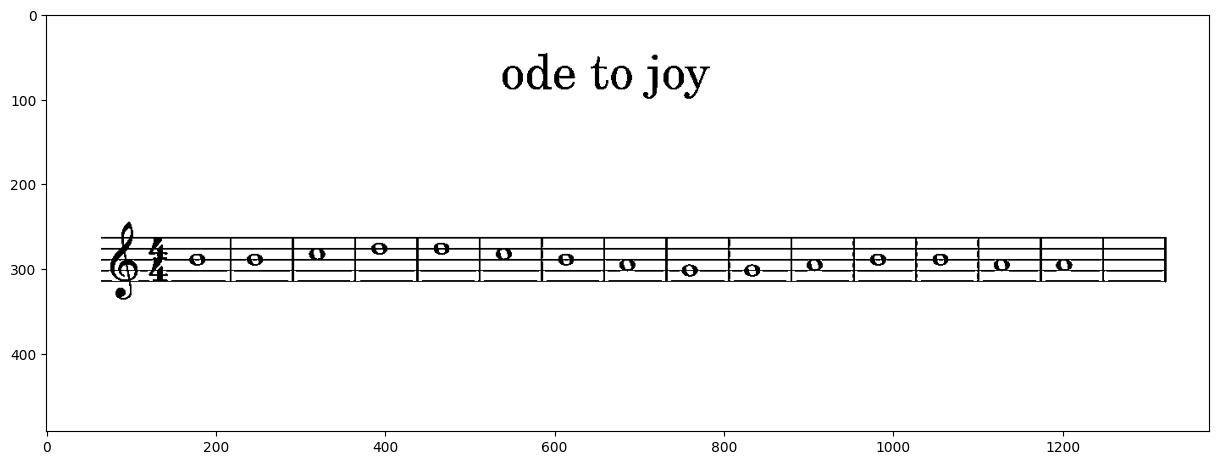

In [3]:
# Aplicar Binarización Adaptativa (ajusta los parámetros según la calidad de la imagen)
binary_img = cv2.adaptiveThreshold(
    image_gray, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, #cv2.THRESH_BINARY_INV
    11, 2
)

# Mostrar la imagen binarizada
plt.imshow(binary_img, cmap='gray')

Línea desde (66, 262) hasta (1321, 262)
Línea desde (66, 275) hasta (1322, 275)
Línea desde (66, 288) hasta (1322, 288)
Línea desde (66, 301) hasta (1322, 301)
Línea desde (66, 313) hasta (1322, 313)
[array([[  66,  262, 1321,  262]], dtype=int32), array([[  66,  275, 1322,  275]], dtype=int32), array([[  66,  288, 1322,  288]], dtype=int32), array([[  66,  301, 1322,  301]], dtype=int32), array([[  66,  313, 1322,  313]], dtype=int32)]
La línea con el menor valor de 'y1' es: [[  66  262 1321  262]]
La línea con el 5 menor valor de 'y1' es: [[  66  313 1322  313]]


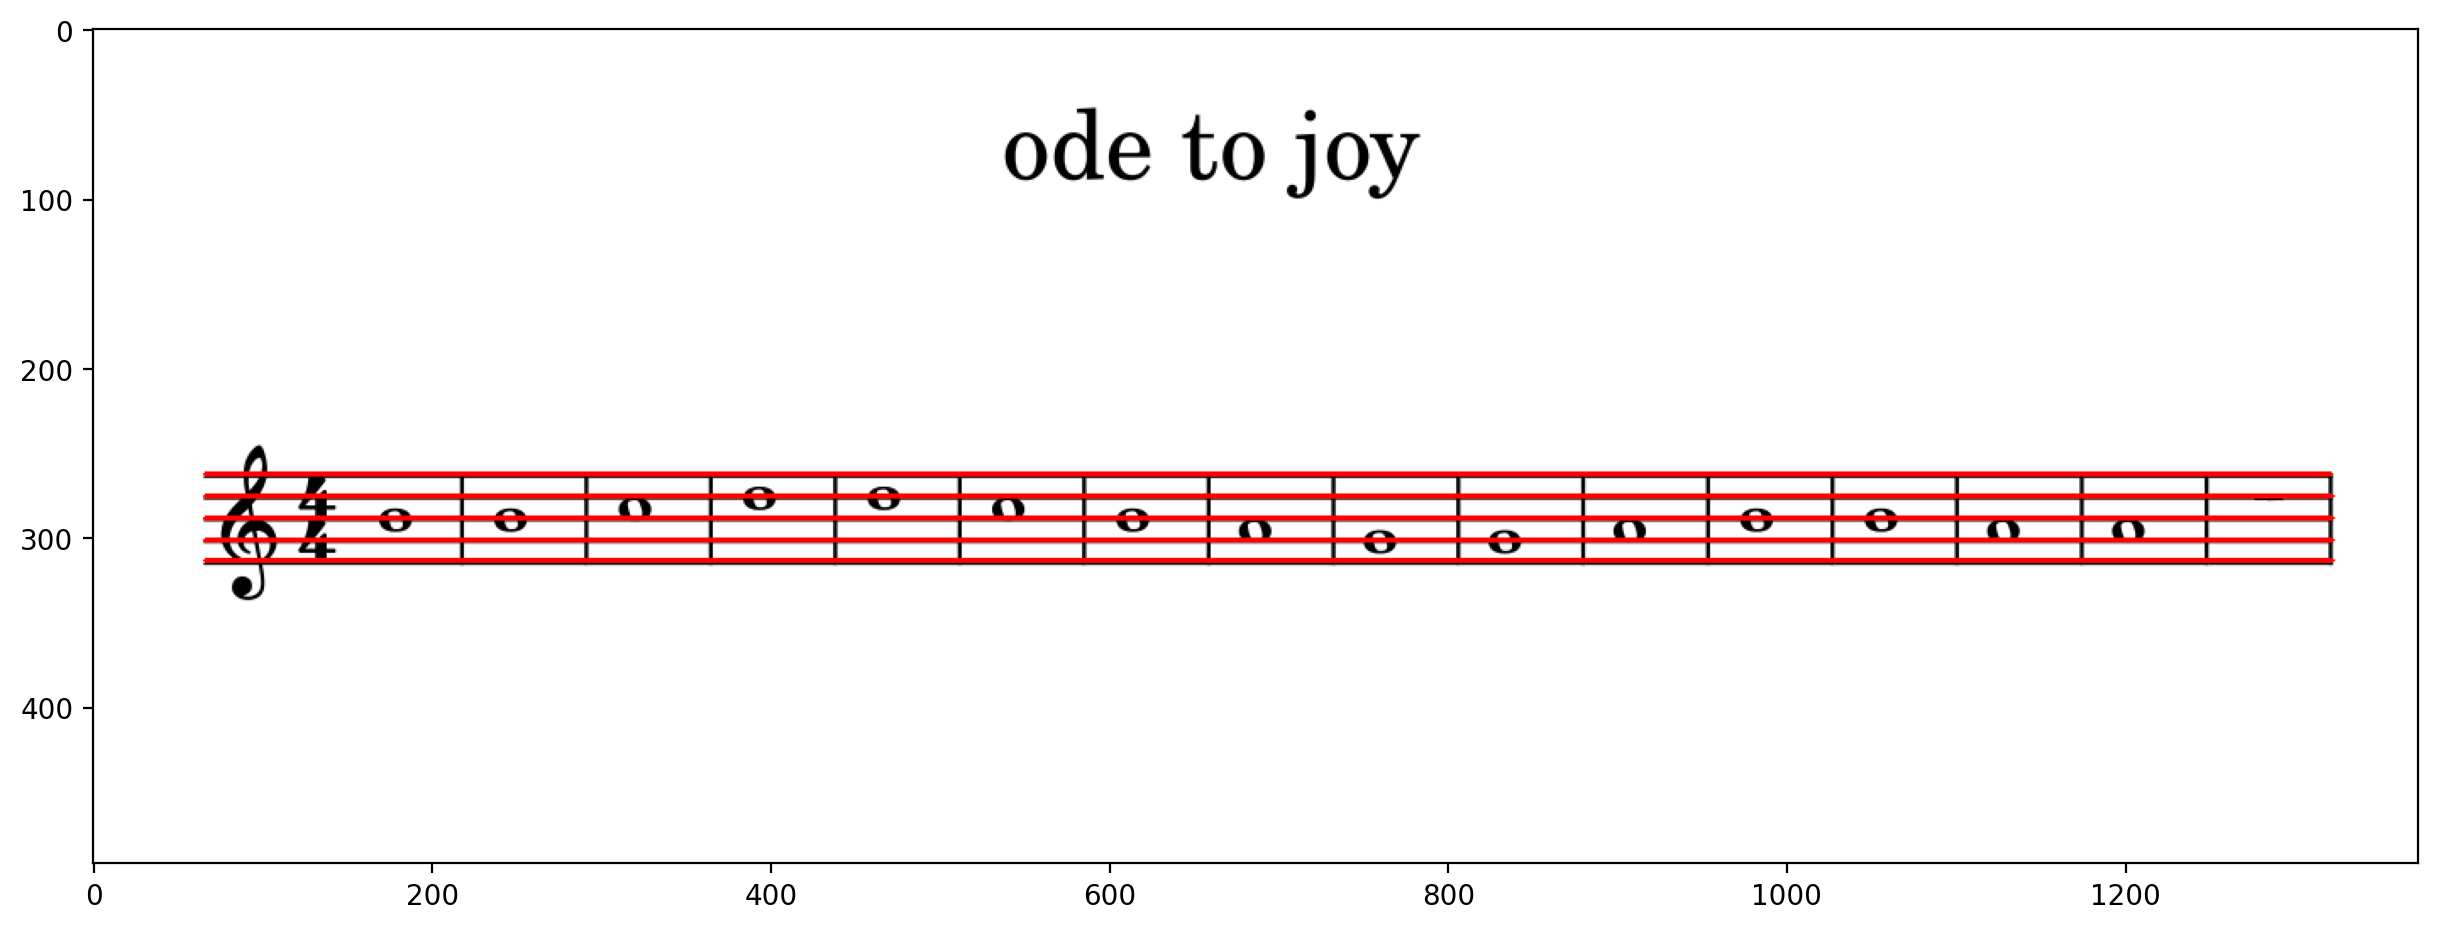

In [4]:
# DETECTAR PENTAGRAMAS

#Aplicar Canny
edges = cv2.Canny(binary_img,100,200,apertureSize = 3)

#Transformada de Hough
rho = 1
theta = np.pi/180
threshold = 350
lines = cv2.HoughLinesP(edges, rho, theta, threshold,
                        minLineLength=50,maxLineGap=30)

#Dibujar líneas detectadas en la imagen original
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(image_color,(x1,y1),(x2,y2),(255,0,0),2)
    print(f"Línea desde ({x1}, {y1}) hasta ({x2}, {y2})")

#Seleccionar primera y quinta línea como referencia
lineas_ordenadas = sorted(lines, key=lambda linea: linea[0][1]) #ordenar por coordenada y1
print(lineas_ordenadas)
print(f"La línea con el menor valor de 'y1' es: {lineas_ordenadas[0]}")
print(f"La línea con el 5 menor valor de 'y1' es: {lineas_ordenadas[4]}")

#Mostrar imagen con líneas detectadas
plt.imshow(image_color)

In [5]:
#VENTANA DESLIZANTE EN FUNCION DE LA DISTANCIA ENTRE LINEAS
linea1 = lineas_ordenadas[0][0] #coordenadas de la primera línea detectada
linea5 = lineas_ordenadas[4][0] #coordenadas de la quinta línea detectada

#dimensiones de la ventana deslizante
w_height = 1.87 * abs(linea5[1] - linea1[1])
w_width = 0.75 * abs(linea5[1] - linea1[1])
w = [int(w_width), int(w_height)]

print(linea1)
print(linea5)

print(f"Tamaño de la ventana deslizante: {w} píxeles")

[  66  262 1321  262]
[  66  313 1322  313]
Tamaño de la ventana deslizante: [38, 95] píxeles


<h2>Embeddings</h2>

Una vez procesada la imagen y obtenido el tamaño de la ventana. Calculamos distintos vectores de características de posibles figuras musicales que puede detectar la ventana.

In [6]:
#Cargar el modelo a usar

device = "cuda" if torch.cuda.is_available() else "cpu"

"""# Cargar ViT-B/16 preentrenado (Vision Transformer)
model = timm.create_model('vit_small_patch16_224', pretrained=True)
model.head = torch.nn.Identity()  #quitamos la capa del clasificador final"""

# Cargar ResNet18 preentrenado
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  #quitamos la capa del clasificador final

model.eval()
model.to(device)

c:\Users\Usuario\OneDrive\Documentos\Escritorio\uni\3_software\visión\proyectoVision\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Usuario\OneDrive\Documentos\Escritorio\uni\3_software\visión\proyectoVision\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
#FUNCIONES PARA EMBEDDINGS

#Transformaciones estándar de imagen
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# Transformaciones de aumento de datos
augment = transforms.Compose([ 
    transforms.RandomResizedCrop(224, scale=(0.9,1.1), ratio=(1.0,1.0)), # escalado
    #transforms.ColorJitter(brightness=0.1, contrast=0.1),  # brillo/contraste
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), # traslación
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

#Devuelve la imagen en PIL.Image RGB
def img_to_pilRGB(img):
    if isinstance(img, str):
        img = Image.open(img)

    elif isinstance(img, np.ndarray):
        # Si viene de OpenCV → BGR → RGB
        if img.ndim == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

    elif isinstance(img, Image.Image):
        pass

    else:
        raise TypeError(f"Tipo de imagen no soportado: {type(img)}")

    return img.convert("RGB")


In [8]:
#Generar embeddings a partir de imágenes del dataset
def get_embedding(img):
    img = img_to_pilRGB(img)

    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model(x)

    emb = emb.squeeze().cpu().numpy()
    emb = emb / np.linalg.norm(emb)

    return emb


#Generar embeddings a partir de aumento de datos de cada imagen original
def get_embedding_aug(img):
    img = img_to_pilRGB(img)

    x = augment(img).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model(x)

    emb = emb.squeeze().cpu().numpy()
    emb = emb / np.linalg.norm(emb)

    return emb

In [9]:
#CARGAR DATASET Y OBTENER EMBEDDINGS
def load_embeddings(folder_path, valid_exts=('.jpg', '.png', '.jpeg')):
    embeddings = []
    filenames = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(valid_exts):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path)
                embedding = get_embedding(img)
                embeddings.append(embedding)
                filenames.append(filename)
                for _ in range(3):  # 5 data augmentations
                    embedding_aug = get_embedding_aug(img)
                    embeddings.append(embedding_aug)
                    filenames.append(filename)
            except Exception as e:
                print(f"Error con el archivo: {filename}")

    return np.array(embeddings), filenames

#Cargar el dataset del siguiente path
embeddings, image_names = load_embeddings("./dataset_OdeToJoy")

#Extraer etiquetas sin números ni extensiones
def extract_label(filename):
    # Elimina números y extensión
    label = re.sub(r'\d+.*$', '', filename)
    return label
labels = [extract_label(name) for name in image_names]

print("Número de imágenes:", len(embeddings))
print("Dimensión del embedding:", embeddings[0].shape)


Número de imágenes: 152
Dimensión del embedding: (512,)


In [ ]:
#GUARDAR EMBEDDINGS Y ETIQUETAS EN UN ARCHIVO .NPZ
"""
#guardar
np.savez(
    "embeddings.npz",
    embeddings=embeddings,   # shape (N, D)
    labels=labels            # lista o array de strings
)

#cargar
data = np.load("embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
labels = data["labels"].tolist()
"""



In [11]:
print(f"Etiquetas del dataset + dataset aumentado: {labels}")

Etiquetas del dataset + dataset aumentado: ['cs', 'cs', 'cs', 'cs', 'cs', 'cs', 'cs', 'cs', 'cs', 'cs', 'cs', 'cs', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rdo', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rla', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rre', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsi', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 'rsol', 't', 't', 't', 't', 't',

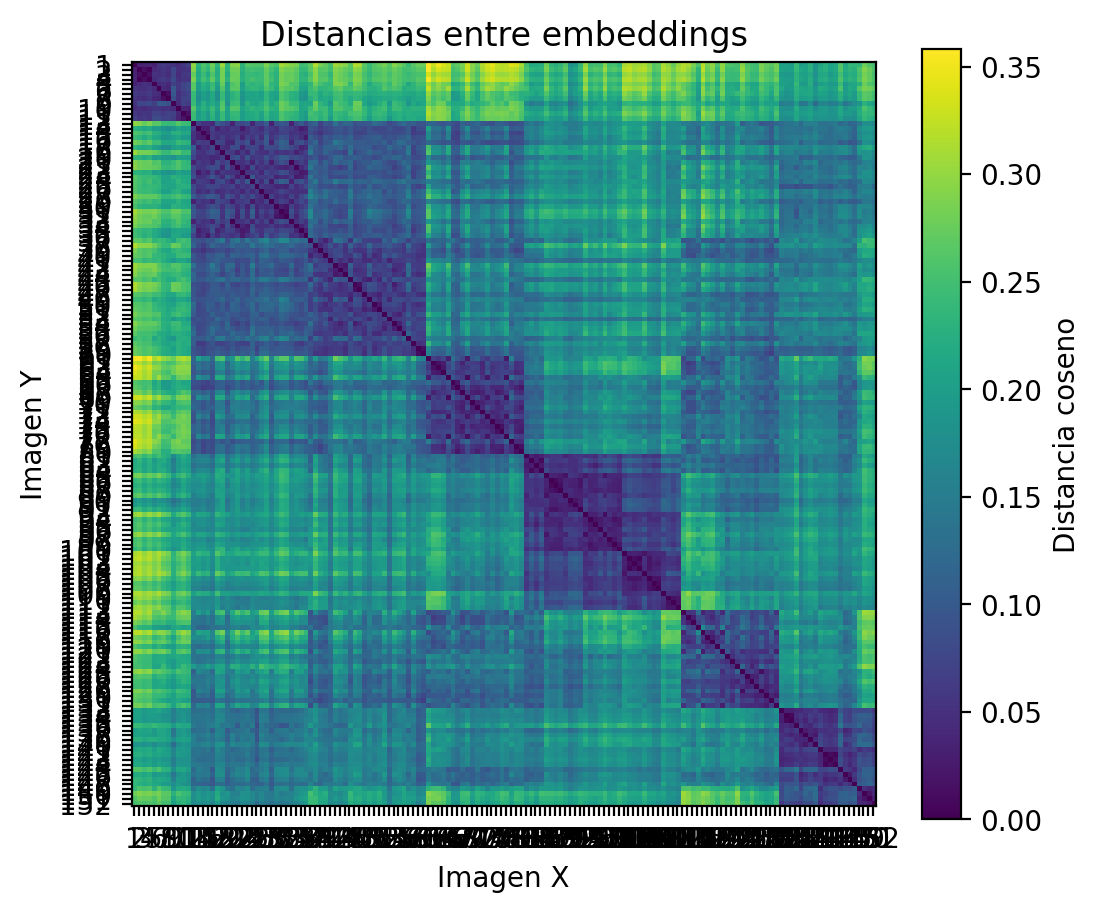

Number of features: (152, 512)


In [12]:
#MATRIZ DE DISTANCIAS ENTRE EMBEDDINGS (distancia coseno)

n = len(embeddings)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = cosine_distances(
            embeddings[i].reshape(1, -1),
            embeddings[j].reshape(1, -1)
        )[0, 0]

#matriz numérica
#print("Matriz de distancias (menor = más similar):\n", np.round(dist_matrix, 3))

#mapa de calor
plt.figure(figsize=(6,5))
im = plt.imshow(dist_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(im, label='Distancia coseno')
plt.title("Distancias entre embeddings")
plt.xlabel("Imagen X")
plt.ylabel("Imagen Y")

# Etiquetas con índices
plt.xticks(range(n), range(1, n+1))
plt.yticks(range(n), range(1, n+1))
plt.show()

print('Number of features:', embeddings.shape)

Original number of features: 512
Reduced number of features: 5


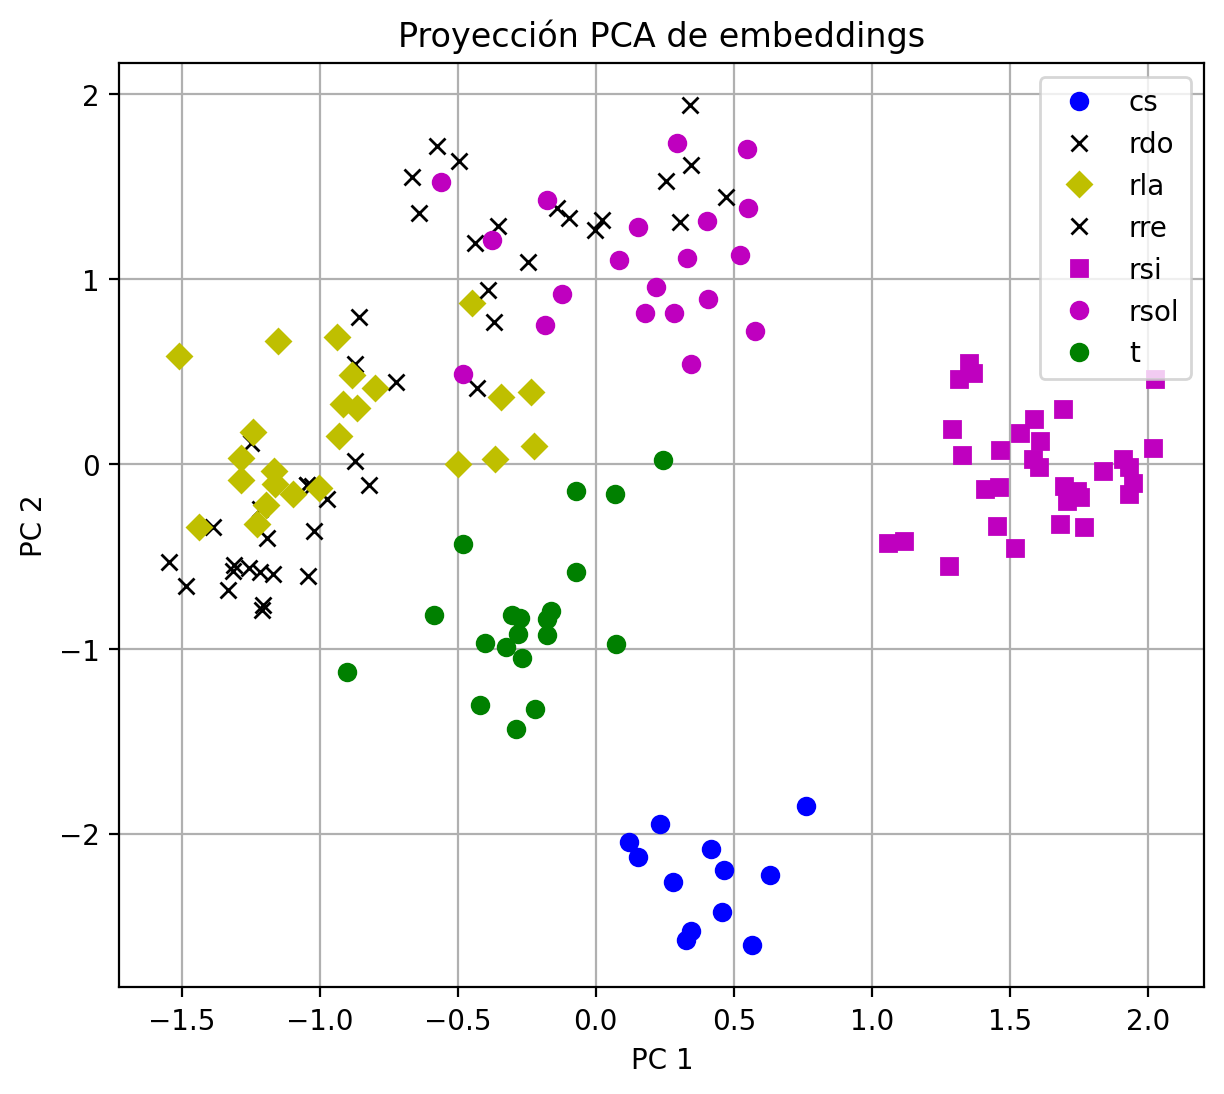

In [13]:
# ESPACIO DE CARACTERÍSTICAS REDUCIDO CON PCA

X = np.array(embeddings)
pca = PCA(n_components=0.6, whiten=True)
X_pca = pca.fit_transform(X)

print("Original number of features:", X.shape[1])
print("Reduced number of features:", X_pca.shape[1])
#print("Resulting features:\n", X_pca)

#Estilos predefinidos para cada etiqueta
styles = {
    "cs":       {"color": "b", "marker": "o"},     # ClaveSol (blue circles)
    "t":        {"color": "g", "marker": "o"},     # Tempo44 (green circles)
    "rfa":      {"color": "c", "marker": "o"},     # Fa (cyan circles)
    "rsol":     {"color": "m", "marker": "o"},     # Sol (magenta circles)
    "rla":      {"color": "y", "marker": "D"},     # La (yellow diamond)
    "rsi":      {"color": "m", "marker": "s"},     # Si (magenta squares)
    "e":        {"color": "r", "marker": "s"},     # xerror (red squares)
}


plt.figure(figsize=(7, 6))

for i, label in enumerate(labels):
    style = styles.get(label, {"color": "k", "marker": "x"})
    plt.plot(
        X_pca[i, 0],
        X_pca[i, 1],
        marker=style["marker"],
        color=style["color"],
        linestyle="None",
        label=label
    )

handles, legend_labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(legend_labels, handles))
plt.legend(unique.values(), unique.keys())

plt.title("Proyección PCA de embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()


Original number of features: 512
Reduced number of features: 3


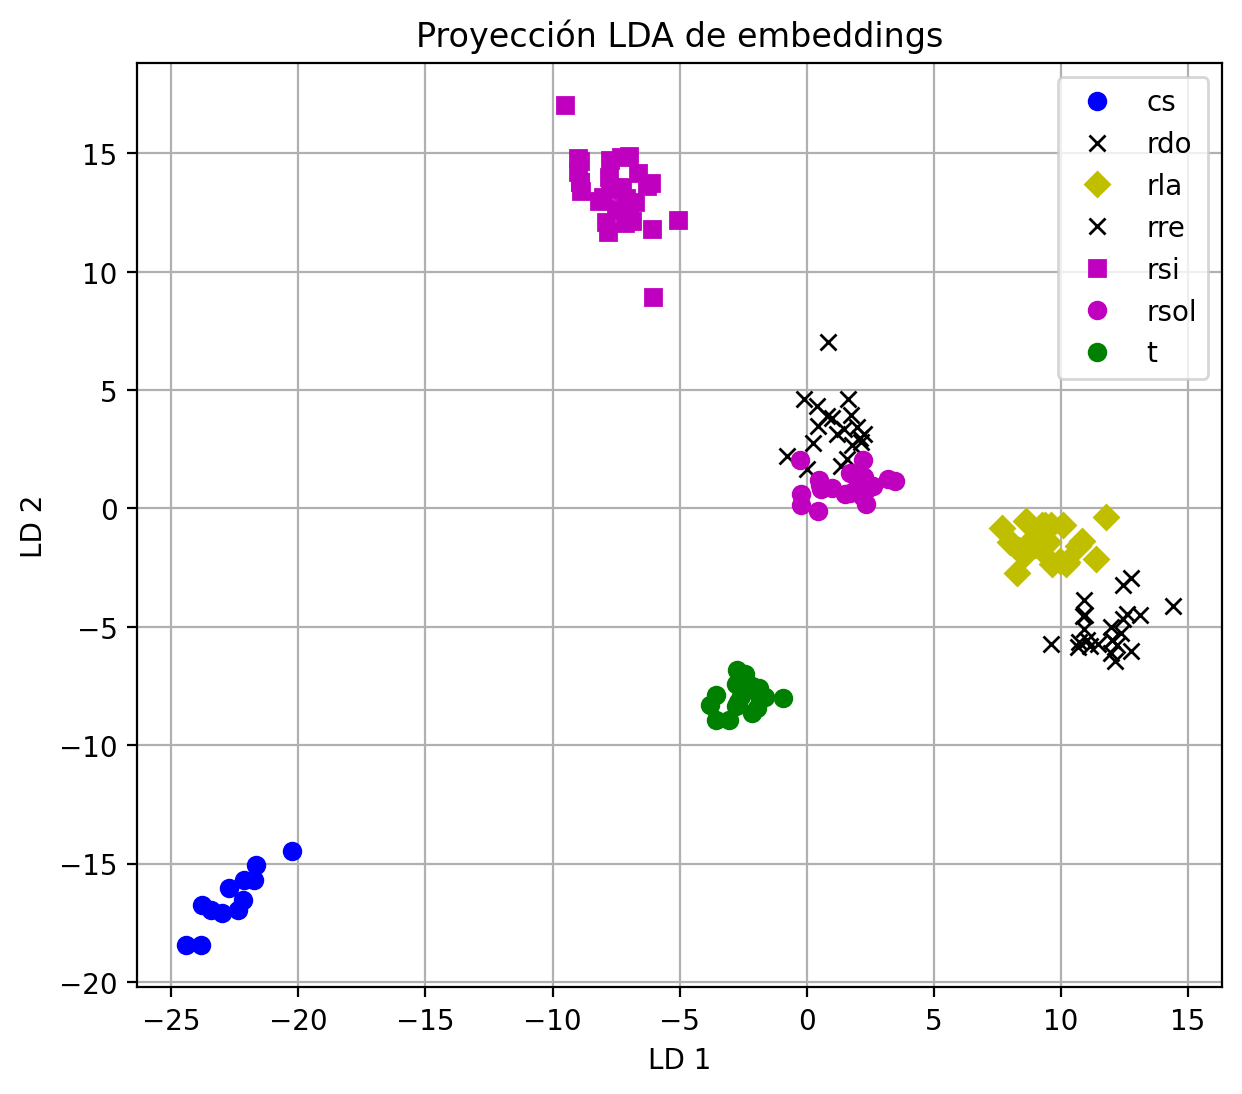

In [14]:
# ESPACIO DE CARACTERÍSTICAS REDUCIDO CON LDA

X = np.array(embeddings)
lda = LinearDiscriminantAnalysis(n_components=3)
X_lda = lda.fit_transform(X, labels)

print("Original number of features:", X.shape[1])
print("Reduced number of features:", X_lda.shape[1])
#print("Resulting features:\n", X_lda)

#Estilos predefinidos para cada etiqueta (ya definidos arriba)

plt.figure(figsize=(7, 6))

for i, label in enumerate(labels):
    style = styles.get(label, {"color": "k", "marker": "x"})
    plt.plot(
        X_lda[i, 0],
        X_lda[i, 1],
        marker=style["marker"],
        color=style["color"],
        linestyle="None",
        label=label
    )

handles, legend_labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(legend_labels, handles))
plt.legend(unique.values(), unique.keys())

plt.title("Proyección LDA de embeddings")
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.grid(True)
plt.show()

(152, 3)


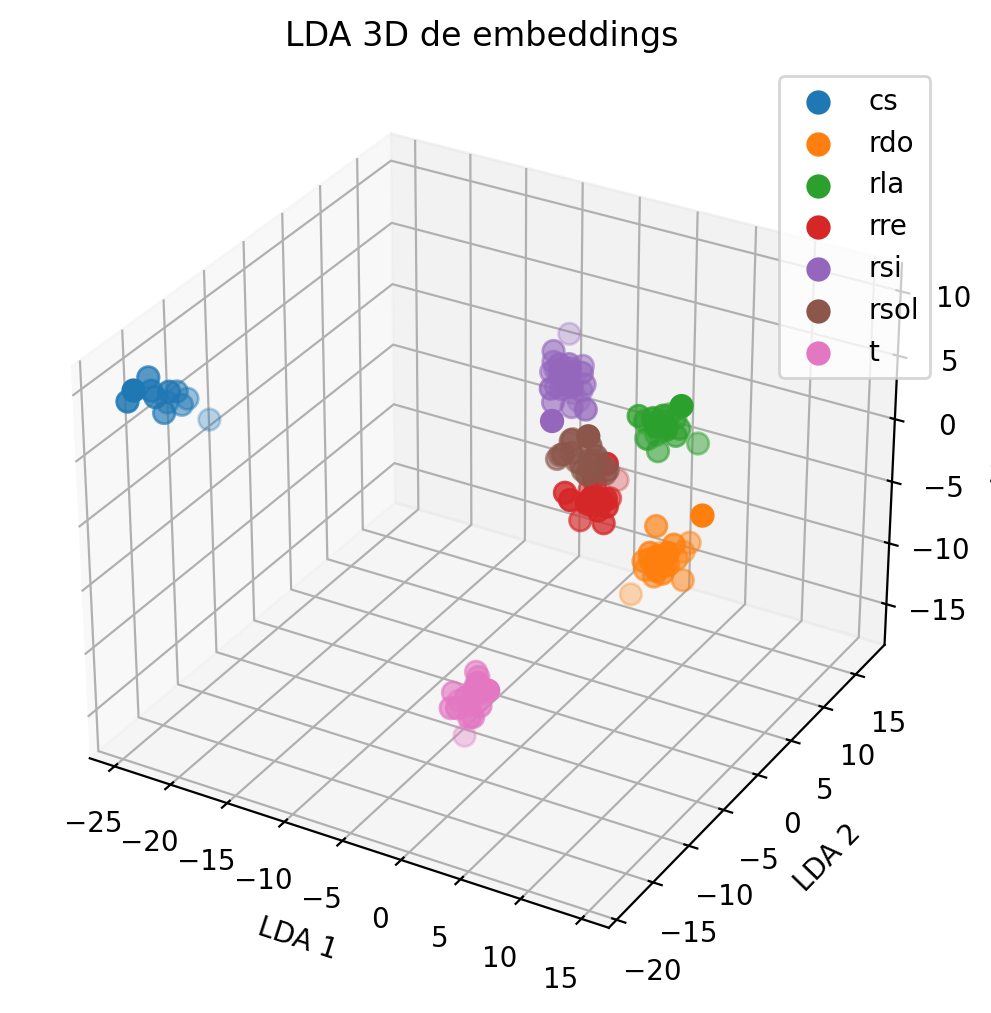

In [15]:
# ESPACIO DE CARACTERÍSTICAS REDUCIDO CON PCA Y LDA

X = np.array(embeddings)
#pca = PCA(n_components=0.8, whiten=True)
#X_pca = pca.fit_transform(X)   # X = features (embeddings + geométricas)
lda = LinearDiscriminantAnalysis(n_components=3)
X_lda = lda.fit_transform(X, labels)
labels = np.array(labels)
print(X_lda.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

labels_unique = np.unique(labels)

for label in labels_unique:
    idx = labels == label
    ax.scatter(
        X_lda[idx, 0],
        X_lda[idx, 1],
        X_lda[idx, 2],
        label=label,
        s=60
    )

ax.set_xlabel("LDA 1")
ax.set_ylabel("LDA 2")
ax.set_zlabel("LDA 3")
ax.set_title("LDA 3D de embeddings")
ax.legend()
plt.show()


<h2>Venta deslizante</h2>

Cuando se han calculado todos los embeddings del dataset y se les ha aplicado técnicas como PCA o LDA, se utiliza la ventana deslizante que se irá desplanzando por el pentagrama para comprobar qué figuras aparecen y almacenarlas.

In [16]:

"""#GUARDAR VENTANAS DESLIZANTES PARA OBTENER MUESTRAS FUTURAS
output_folder = "./ventanas_guardadas"
os.makedirs(output_folder, exist_ok=True)  # crea la carpeta si no existe"""


'#GUARDAR VENTANAS DESLIZANTES PARA OBTENER MUESTRAS FUTURAS\noutput_folder = "./ventanas_guardadas"\nos.makedirs(output_folder, exist_ok=True)  # crea la carpeta si no existe'

In [20]:
def sliding_window(image, start_x, start_y, window_size, step_x):
    #Genera recortes 2D de una imagen (matriz NumPy) comenzando en (start_x, start_y)
    
    #dimensiones de la imagen y ventana
    (height, width) = image.shape
    win_w, win_h = window_size

    #coordenadas iniciales
    x = start_x
    y = start_y
    i = 0
    
    #recorremos X manteniendo Y fijo (start_y)
    while (x + win_w) <= width:
        # Slicing --> [fila_fija : (fila_fija + alto_wind), columna_movil : columna_movil + ancho_wind]
        window = image[start_y:start_y + win_h, x:x + win_w] 

        """#guardar la ventana para futuras muestras
        window_filename = f"ventana_{i}_{x}_{y}.jpg"
        window_path = os.path.join(output_folder, window_filename)
        cv2.imwrite(window_path, window)  # guarda en escala de grises"""


        embedding_new = get_embedding(window).reshape(1, -1)  # forma 2D
        #embedding_new = pca.transform(embedding_new)  # aplicar PCA
        embedding_new = lda.transform(embedding_new)  # aplicar LDA
        
        i += 1

        #Calcular distancia con KNN
        nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(X_lda)
        distances, indices = nbrs.kneighbors(embedding_new)
        labels_knn = [labels[i] for i in indices[0]]
        pred_label = Counter(labels_knn).most_common(1)[0][0]
        # Distancia promedio a los vecinos que pertenecen a la pred_label
        dist_to_pred_label = [distances[0][i] for i, idx in enumerate(indices[0]) if labels[idx] == pred_label]
        avg_distance = sum(dist_to_pred_label) / len(dist_to_pred_label)
        closest_distance = avg_distance

        
        """#Calcular distancia coseno con todo el dataset
        distances = cosine_distances(embedding_new, X_lda)  # shape (1, 12)
        closest_idx = np.argmin(distances)
        closest_distance = distances[0, closest_idx] if distances.ndim == 2 else distances[closest_idx]
        pred_label = labels[closest_idx]"""
        

        print(f"Distancia: {closest_distance:.4f}")
        confidence_threshold = 0.02 #ajustar 

        #si la distancia mínima es menor que el umbral
        if closest_distance <= confidence_threshold:
            yield (x, y, window, pred_label, closest_distance)
            x = int(x + step_x) #avanzar ventana poco a poco
            print(f"La imagen es: {pred_label} \n")

            #si es clave de sol y es de las primeras ventanas
            if(pred_label=="cs" and i<5):
                win_w = int(win_w*0.70) #dim ventana

        #si la distancia mínima es mayor que el umbral
        else:
            yield (x, y, window, " ", closest_distance)
            print("La imagen es: DESCONOCIDA (Ninguno de los Casos)\n")
            x = int(x + step_x) #avanzar ventana poco a poco
    

<h2>Escanear partitura</h2>

Distancia: 0.0017
La imagen es: cs 

Distancia: 0.3142
La imagen es: DESCONOCIDA (Ninguno de los Casos)

Distancia: 0.3585
La imagen es: DESCONOCIDA (Ninguno de los Casos)

Distancia: 0.0647
La imagen es: DESCONOCIDA (Ninguno de los Casos)

Distancia: 0.1772
La imagen es: DESCONOCIDA (Ninguno de los Casos)

Distancia: 0.0116
La imagen es: t 

Distancia: 0.0092
La imagen es: t 

Distancia: 0.0079
La imagen es: t 

Distancia: 0.1457
La imagen es: DESCONOCIDA (Ninguno de los Casos)

Distancia: 0.1140
La imagen es: DESCONOCIDA (Ninguno de los Casos)

Distancia: 0.1653
La imagen es: DESCONOCIDA (Ninguno de los Casos)

Distancia: 0.0398
La imagen es: DESCONOCIDA (Ninguno de los Casos)

Distancia: 0.0005
La imagen es: rsi 

Distancia: 0.0002
La imagen es: rsi 

Distancia: 0.0230
La imagen es: DESCONOCIDA (Ninguno de los Casos)

Distancia: 0.0048
La imagen es: rsi 

Distancia: 0.0290
La imagen es: DESCONOCIDA (Ninguno de los Casos)

Distancia: 0.4278
La imagen es: DESCONOCIDA (Ninguno de los C

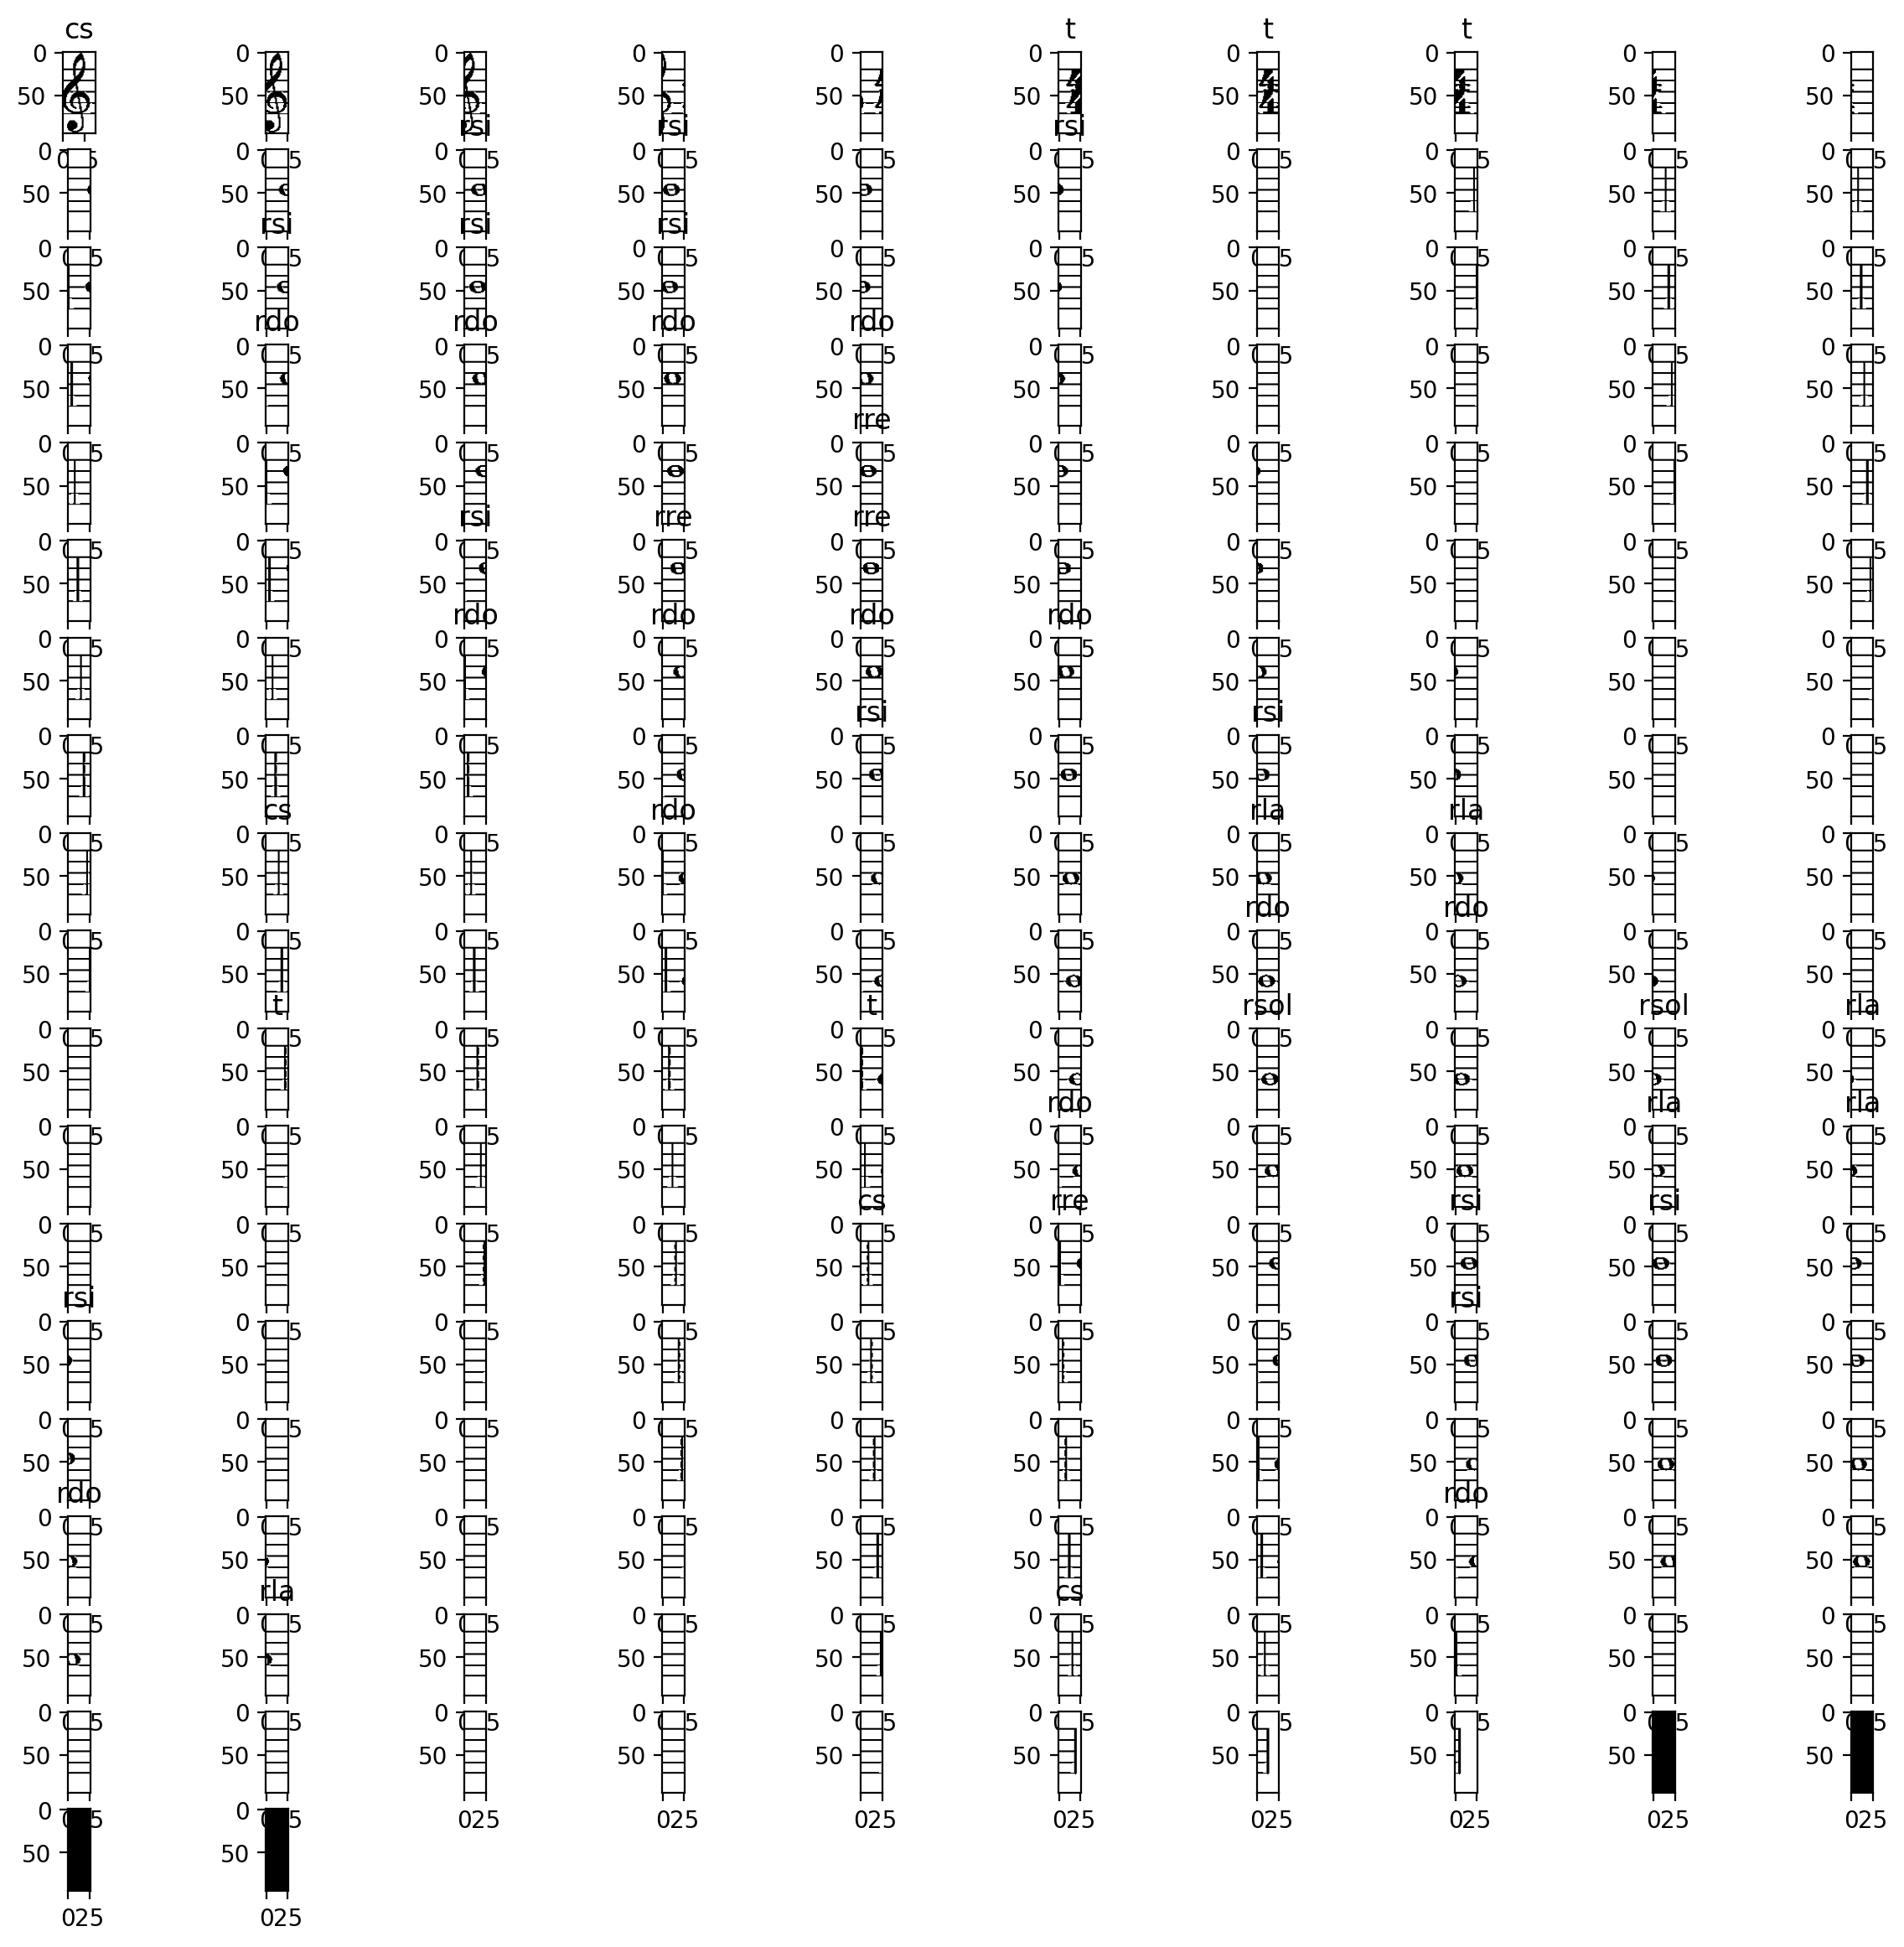

In [21]:
#ANALIZAR PARTITURA CON VENTANA DESLIZANTE Y EMBEDDINGS

simbolos = []
detections = []
# Recorrer las ventanas
for i, (x, y, ventana, label, closest_distance) in enumerate(sliding_window(binary_img, int(linea1[0]+w[0]*0.3), int(linea1[1]-w[1]*0.2), w, int(w[0]/5))):
    simbolos.append(label)

    #Mostar cada ventana y su etiqueta
    plt.subplot(20,10,i+1) #plt.subplot(12,10,i+1)
    plt.imshow(ventana, cmap='gray') 
    plt.title(label)

    #almacenar detección si no es desconocido ni error
    if label != " " and label != "e":
        score = 1 - closest_distance  #o cualquier medida de confianza
        detections.append((x, ventana.shape[1], score, label))

print(simbolos)

In [23]:
#todas las figuras detectadas (sin desconocido ni error)
notas = [s for s in simbolos if s != " " and s != "e" ]
print(notas)

[np.str_('cs'), np.str_('t'), np.str_('t'), np.str_('t'), np.str_('rsi'), np.str_('rsi'), np.str_('rsi'), np.str_('rsi'), np.str_('rsi'), np.str_('rsi'), np.str_('rdo'), np.str_('rdo'), np.str_('rdo'), np.str_('rdo'), np.str_('rre'), np.str_('rsi'), np.str_('rre'), np.str_('rre'), np.str_('rdo'), np.str_('rdo'), np.str_('rdo'), np.str_('rdo'), np.str_('rsi'), np.str_('rsi'), np.str_('cs'), np.str_('rdo'), np.str_('rla'), np.str_('rla'), np.str_('rdo'), np.str_('rdo'), np.str_('t'), np.str_('t'), np.str_('rsol'), np.str_('rsol'), np.str_('rla'), np.str_('rdo'), np.str_('rla'), np.str_('rla'), np.str_('cs'), np.str_('rre'), np.str_('rsi'), np.str_('rsi'), np.str_('rsi'), np.str_('rsi'), np.str_('rdo'), np.str_('rdo'), np.str_('rla'), np.str_('cs')]


In [24]:
#SUPRESIÓN DE NO MÁXIMOS (cuando se detecta varias veces la misma nota)

def non_max_suppression(detections, solapamiento):
    if len(detections) == 0:
        return []

    #ordenar por score descendente
    detections = sorted(detections, key=lambda x: x[1], reverse=True) #Para cada elemento x, fíjate solo en el de la posición 1 (coordenada X)
    keep = []

    while detections:
        #tomar la detección más confiable
        best = detections.pop(0)
        keep.append(best)

        to_delete = []
        to_compare = []
        for i, (x, best_width,score, label) in enumerate(detections):
            #calcular solapamiento en X (distancia relativa al ancho de la ventana)
            if abs(x - best[0]) < best_width * solapamiento:
                to_compare.append((i, x, best_width,score, label))
        
        if to_compare:
            #clase más repetida
            labels = [label for (_, _, _, _, label) in to_compare]
            counter = Counter(labels)
            max_reps = max(counter.values())
            print(counter)

            labels_mayoritarias = [
                lbl for lbl, cnt in counter.items() if cnt == max_reps
            ]

            #desempate por score
            candidatos = [
                det for det in to_compare if det[4] in labels_mayoritarias
            ]
            best = max(candidatos, key=lambda x: x[3])

            #eliminar el resto
            for (i, x, best_width, score, label) in to_compare:
                if (i, x, best_width, score, label) != best:
                    to_delete.append(i)
        
        # Eliminar detecciones solapadas
        for i in reversed(to_delete):
            detections.pop(i)

        
    return keep


#Aplicar función de supresión de no máximos
final_detections = non_max_suppression(detections, solapamiento=3.5)

Counter({np.str_('t'): 3, np.str_('rsi'): 1})
Counter({np.str_('rsi'): 2})
Counter({np.str_('rsi'): 3})
Counter({np.str_('rdo'): 3})
Counter({np.str_('rdo'): 1, np.str_('rre'): 1})
Counter({np.str_('rre'): 2, np.str_('rsi'): 1})
Counter({np.str_('rdo'): 4})
Counter({np.str_('rsi'): 2})
Counter({np.str_('cs'): 1, np.str_('rdo'): 1, np.str_('rla'): 1})
Counter({np.str_('rdo'): 2, np.str_('rla'): 1})
Counter({np.str_('t'): 2, np.str_('rsol'): 2})
Counter({np.str_('rla'): 1})
Counter({np.str_('rla'): 2, np.str_('rdo'): 1})
Counter({np.str_('rsi'): 3, np.str_('cs'): 1, np.str_('rre'): 1})
Counter({np.str_('rsi'): 1})
Counter({np.str_('rdo'): 1, np.str_('rla'): 1})
Counter({np.str_('cs'): 1})


In [25]:
#Mostrar resultados
for x, ventana, score, label in final_detections:
    print(f"x={x}, label={label}, score={score:.3f}")

x=77, label=cs, score=0.998
x=126, label=t, score=0.992
x=168, label=rsi, score=1.000
x=224, label=rsi, score=1.000
x=301, label=rdo, score=1.000
x=385, label=rre, score=0.993
x=455, label=rre, score=0.997
x=532, label=rdo, score=0.998
x=595, label=rsi, score=0.994
x=679, label=rla, score=0.993
x=749, label=rdo, score=0.997
x=784, label=t, score=0.985
x=840, label=rla, score=0.989
x=910, label=rla, score=0.999
x=966, label=rsi, score=0.999
x=1036, label=rsi, score=0.991
x=1127, label=rdo, score=0.994
x=1204, label=rla, score=0.996
x=1232, label=cs, score=0.990


<h2>Transcripción a audio (.mid) y archivo (.xml)</h2>

In [26]:
#TRANSCRIBIR DATOS (detections)

# Crear un objeto partitura (se usar Score en vez de Stream si hay más de una voz)
partitura = stream.Stream()

partitura.metadata = metadata.Metadata()
partitura.metadata.title = 'Partitura Visión Ode To Joy'
partitura.metadata.composer = 'PentaScan'

# Asignar piano por defecto
partitura.insert(0, instrument.Piano())

for _, _, _, simbolo in final_detections:
    if simbolo == "rfa":
        n = note.Note("F4")
        n.duration.quarterLength = 4  #duración de redonda
        partitura.append(n)
    elif simbolo == "rsol":
        n = note.Note("G4")
        n.duration.quarterLength = 4
        partitura.append(n)
    elif simbolo == "rla":
        n = note.Note("A4")
        n.duration.quarterLength = 4
        partitura.append(n)
    elif simbolo == "rsi":
        n = note.Note("B4")
        n.duration.quarterLength = 4
        partitura.append(n)
    elif simbolo == "rdo":
        n = note.Note("C5")
        n.duration.quarterLength = 4
        partitura.append(n)
    elif simbolo == "rre":
        n = note.Note("D5")
        n.duration.quarterLength = 4
        partitura.append(n)
    elif simbolo == "t":
        # Añadir indicación de tempo (no es una nota)
        tempo_marking = music21.tempo.MetronomeMark(number=44)
        partitura.append(tempo_marking)
    else:
        # Manejar otros símbolos o errores
        #si es clave de sol no hace nada porque se añade automáticamente
        pass #se pone esto porque no se hace nada dentro del else



In [27]:
#ARCHIVO MusicXML
partitura.write('musicxml', fp='mi_partitura_OdeToJoy.xml') #guarda la partitura para abrirla con musescore

WindowsPath('c:/Users/Usuario/OneDrive/Documentos/Escritorio/uni/3_software/visión/proyectoVision/PentaScan/PentaScan_OdeToJoy/mi_partitura_OdeToJoy.xml')

In [28]:
#ARCHIVO MIDI
archivo_midi = "mi_partitura_OdeToJoy.mid"
partitura.write('midi', fp=archivo_midi) #guarda el audio con el instrumento asignado


partitura.show('midi')  # se abre al ejecutar el código